In [1]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import networkx as nx
import random
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from umap.umap_ import UMAP


/Users/hana/anaconda3/envs/data/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
subject_dict= {'A': 'Manuals', 'B': 'Italian Art', 'C': 'Italian Artists', 'D': 'Rome','E':'Italian Topography', 'F': 'Travel Literature', 
               'G': 'Sources', 'H': 'Iconography', 'J': 'Ornament','K': 'Kat and K', 'L': 'Congress Publications', 'M': 'Art in General',
                'N': 'Architecture', 'O':'Sculpture', 'P': 'Painting', 'Q': 'Manuscript Illumination', 'R': 'Graphic Arts', 
               'S': 'Applied Arts', 'T': 'Collecting Art, Museum Studies', 'U': 'Registers of Artistic Monuments', 'V': 'Cultural Institutions', 
               'W': 'Non-Italian Artists','X': 'European Topography', 'Y': 'World Topography', 'Z': 'Related Disciplines', ' ': 'None'}


custom_colours = ["#EA522B", "#EFD4D1", "#2A4978", "#8BDBE1", "#ECA19D", "#B48E36", "#E1DCE0", "#B8BFCE", "#E0DCD1", "#91C5E4", 
                  "#6E8EAC", "#D2E7E0", "#ECD096", "#6C9686", "#E6E10F", "#9D4B37", "#A3B49D", "#BDC920", "#DBE3E5", "#6A8B8D", "#EFB3D1"]

user_type_colors = {'Internal': "#EA522B", 'External': "#2A4978"}
custom_cmap = ListedColormap(custom_colours)

# User data
 
I'm trying out different approches here: 
 - Visualising the books using the titles and applying LDA for topic extraction
 - Visualising the books using the titles and user data as metric
 - Visualising the users using common books as metric
 - Using networkx to create a network of books
 

In [13]:
user_df = pd.DataFrame()

csv_directory = '../user_data'

for filename in os.listdir(csv_directory):
    if filename.endswith(".csv"):
        year = filename.split('.')[0]
        file_path = os.path.join(csv_directory, filename)
        df = pd.read_csv(file_path, delimiter=';',encoding='ISO-8859-1',low_memory=False)
        user_df = pd.concat([user_df, df], ignore_index=True)

# To datetime
user_df['Z36H_LOAN_DATE'] = pd.to_datetime(user_df['Z36H_LOAN_DATE'], format='%Y%m%d', errors='coerce')
user_df['Z36H_RETURNED_DATE'] = pd.to_datetime(user_df['Z36H_RETURNED_DATE'], format='%Y%m%d', errors='coerce')
user_df.dropna(subset=['Z36H_LOAN_DATE'], inplace=True)
user_df['Year'] = user_df['Z36H_LOAN_DATE'].dt.year

# Clean up 2014
mask = user_df['Year'] == 2014
user_df.loc[mask, 'Z30_CALL_NO'] = user_df.loc[mask, 'ï»¿Z30_CALL_NO']
user_df = user_df.drop('ï»¿Z30_CALL_NO', axis=1)

# Drop 2012
user_df = user_df[user_df.Year != 2012]

user_df.to_csv('../users.csv',index=False)


In [14]:
user_df.sample()

,Z30_CALL_NO,Z30_COLLECTION,Z30_BARCODE,Z30_INVENTORY_NUMBER,Z30_DESCRIPTION,Z30_NO_LOANS,Z36H_LOAN_DATE,Z36H_RETURNED_DATE,Z36H_ID,Z36H_LOAN_CATALOGER_NAME,Z13_TITLE,Year
299907,Ca-CAR 317-5911,BIB,E00401080D2E8409,1992.1921,NaN,10.0,2016-01-19,2016-01-19,MPG000012952,SELFCHECK,Caravaggio,2016


## User data analysis

In [6]:
print('Unique users in dataset: {}'.format(user_df.Z36H_ID.unique().size))
print('Unique books in dataset: {}'.format(user_df.Z30_CALL_NO.unique().size))

Unique users in dataset: 739
Unique books in dataset: 96372


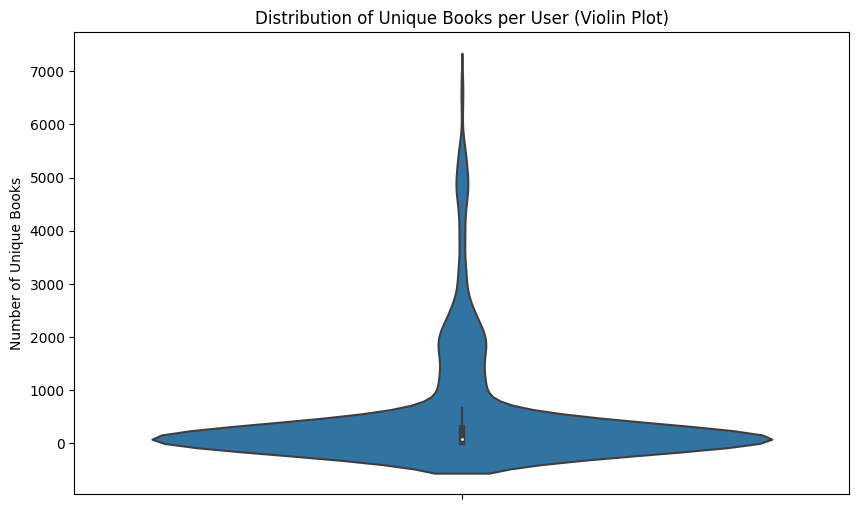

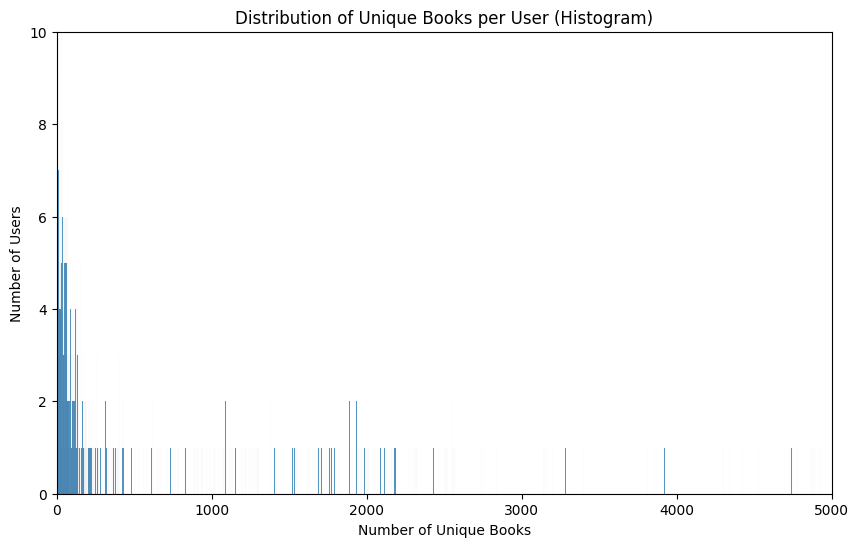

In [7]:
user_book_counts = user_df.groupby('Z36H_ID')['Z30_CALL_NO'].nunique()

# Create a violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(y=user_book_counts)
plt.title('Distribution of Unique Books per User (Violin Plot)')
plt.ylabel('Number of Unique Books')
plt.show()

# Create a bar plot (histogram) with specified axis limits
plt.figure(figsize=(10, 6))
sns.histplot(user_book_counts, bins=range(min(user_book_counts), min(5000, max(user_book_counts) + 1)), kde=False)
plt.title('Distribution of Unique Books per User (Histogram)')
plt.xlabel('Number of Unique Books')
plt.ylabel('Number of Users')
plt.ylim(0, 10)  # Set the y-axis limits
plt.xlim(0, 5000)  # Set the x-axis limits
plt.show()

In [8]:
# Are top users internal? 
top_users = user_book_counts.sort_values(ascending=False).head(100)
bhr_users = top_users[top_users.index.str.startswith('BHR')]

print(f"Percentage of 'BHR' Users in Top 100: {bhr_users.count()/100:.2f}%")


Percentage of 'BHR' Users in Top 100: 0.00%


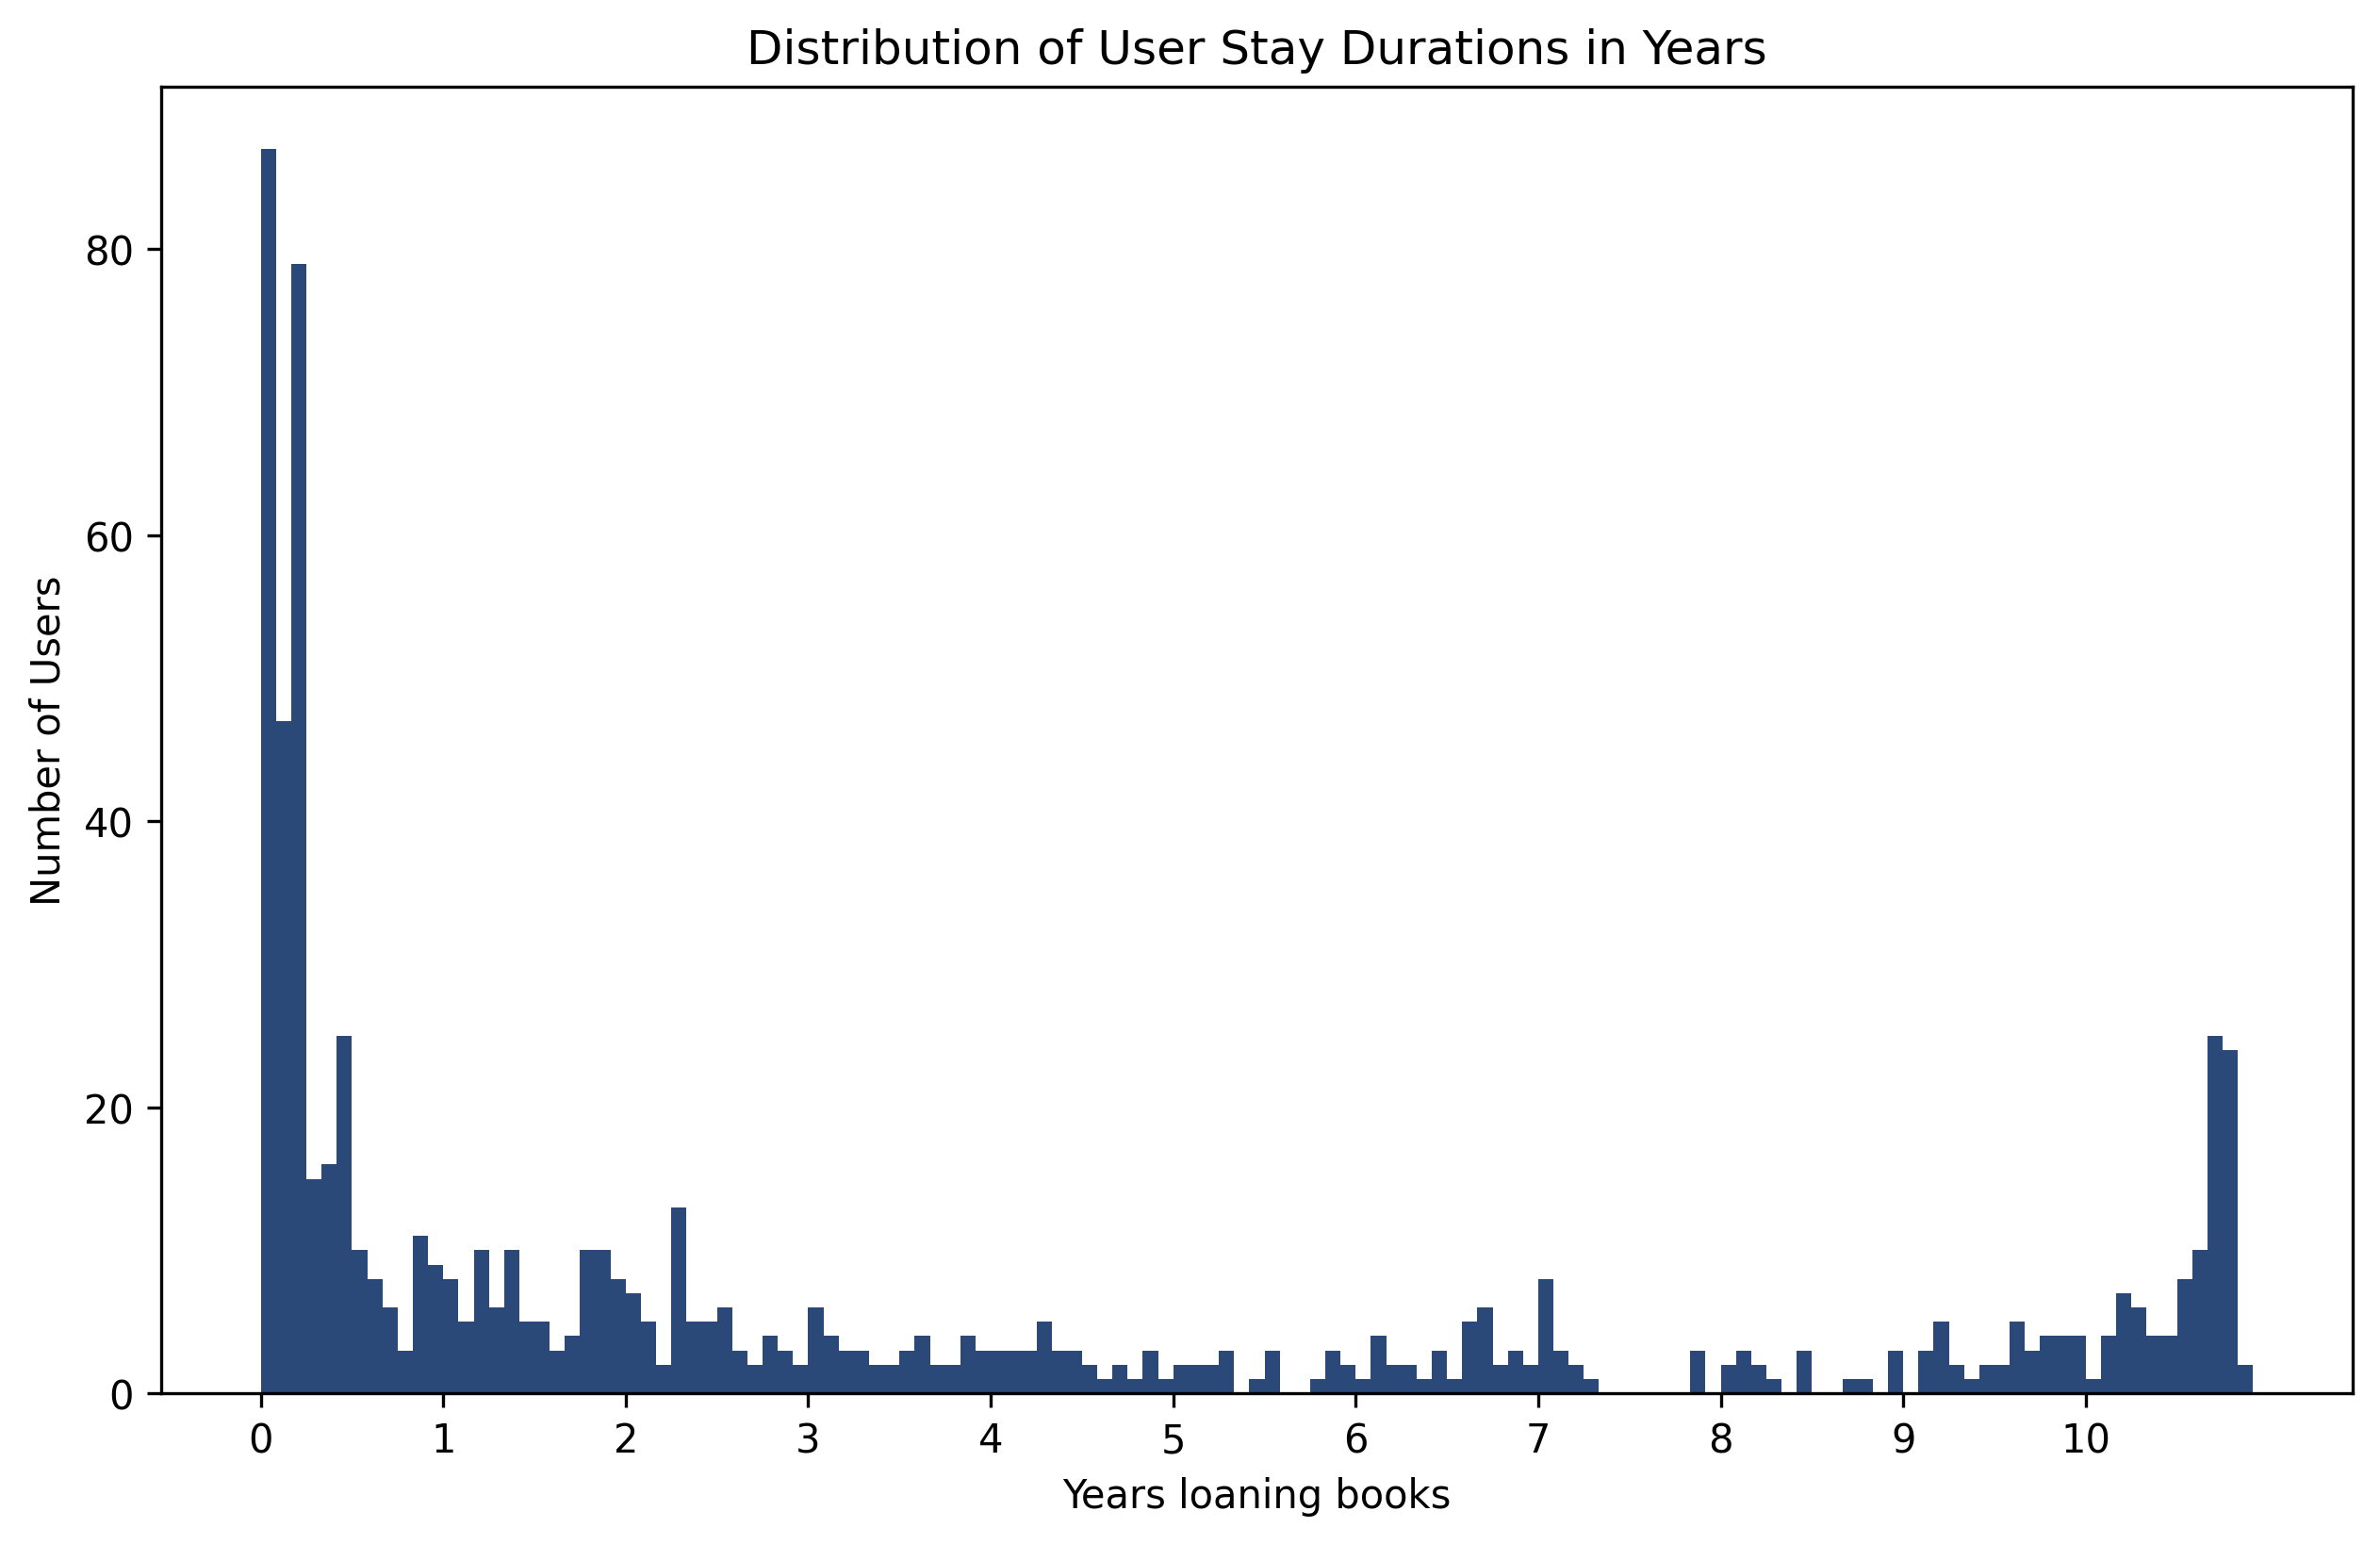

In [23]:
# Calculate the first and last loan dates for each user
user_first_loan_date = user_df.groupby('Z36H_ID')['Z36H_LOAN_DATE'].min()
user_last_loan_date = user_df.groupby('Z36H_ID')['Z36H_LOAN_DATE'].max()

# Calculate the duration of stay in the library for each user in years
user_stay_duration_months = (user_last_loan_date - user_first_loan_date).dt.days // 30 

plt.figure(figsize=(10, 6), dpi=300)
bins = np.arange(0, user_stay_duration_months.max() + 2, 1)
plt.hist(user_stay_duration_months, bins=bins, color='#2A4978')
plt.title('Distribution of User Stay Durations in Years')
plt.xlabel('Years loaning books')
plt.ylabel('Number of Users')

x_ticks = np.arange(0, (user_stay_duration_months.max() + 1), 12)
plt.xticks(x_ticks, x_ticks // 12)

plt.show()

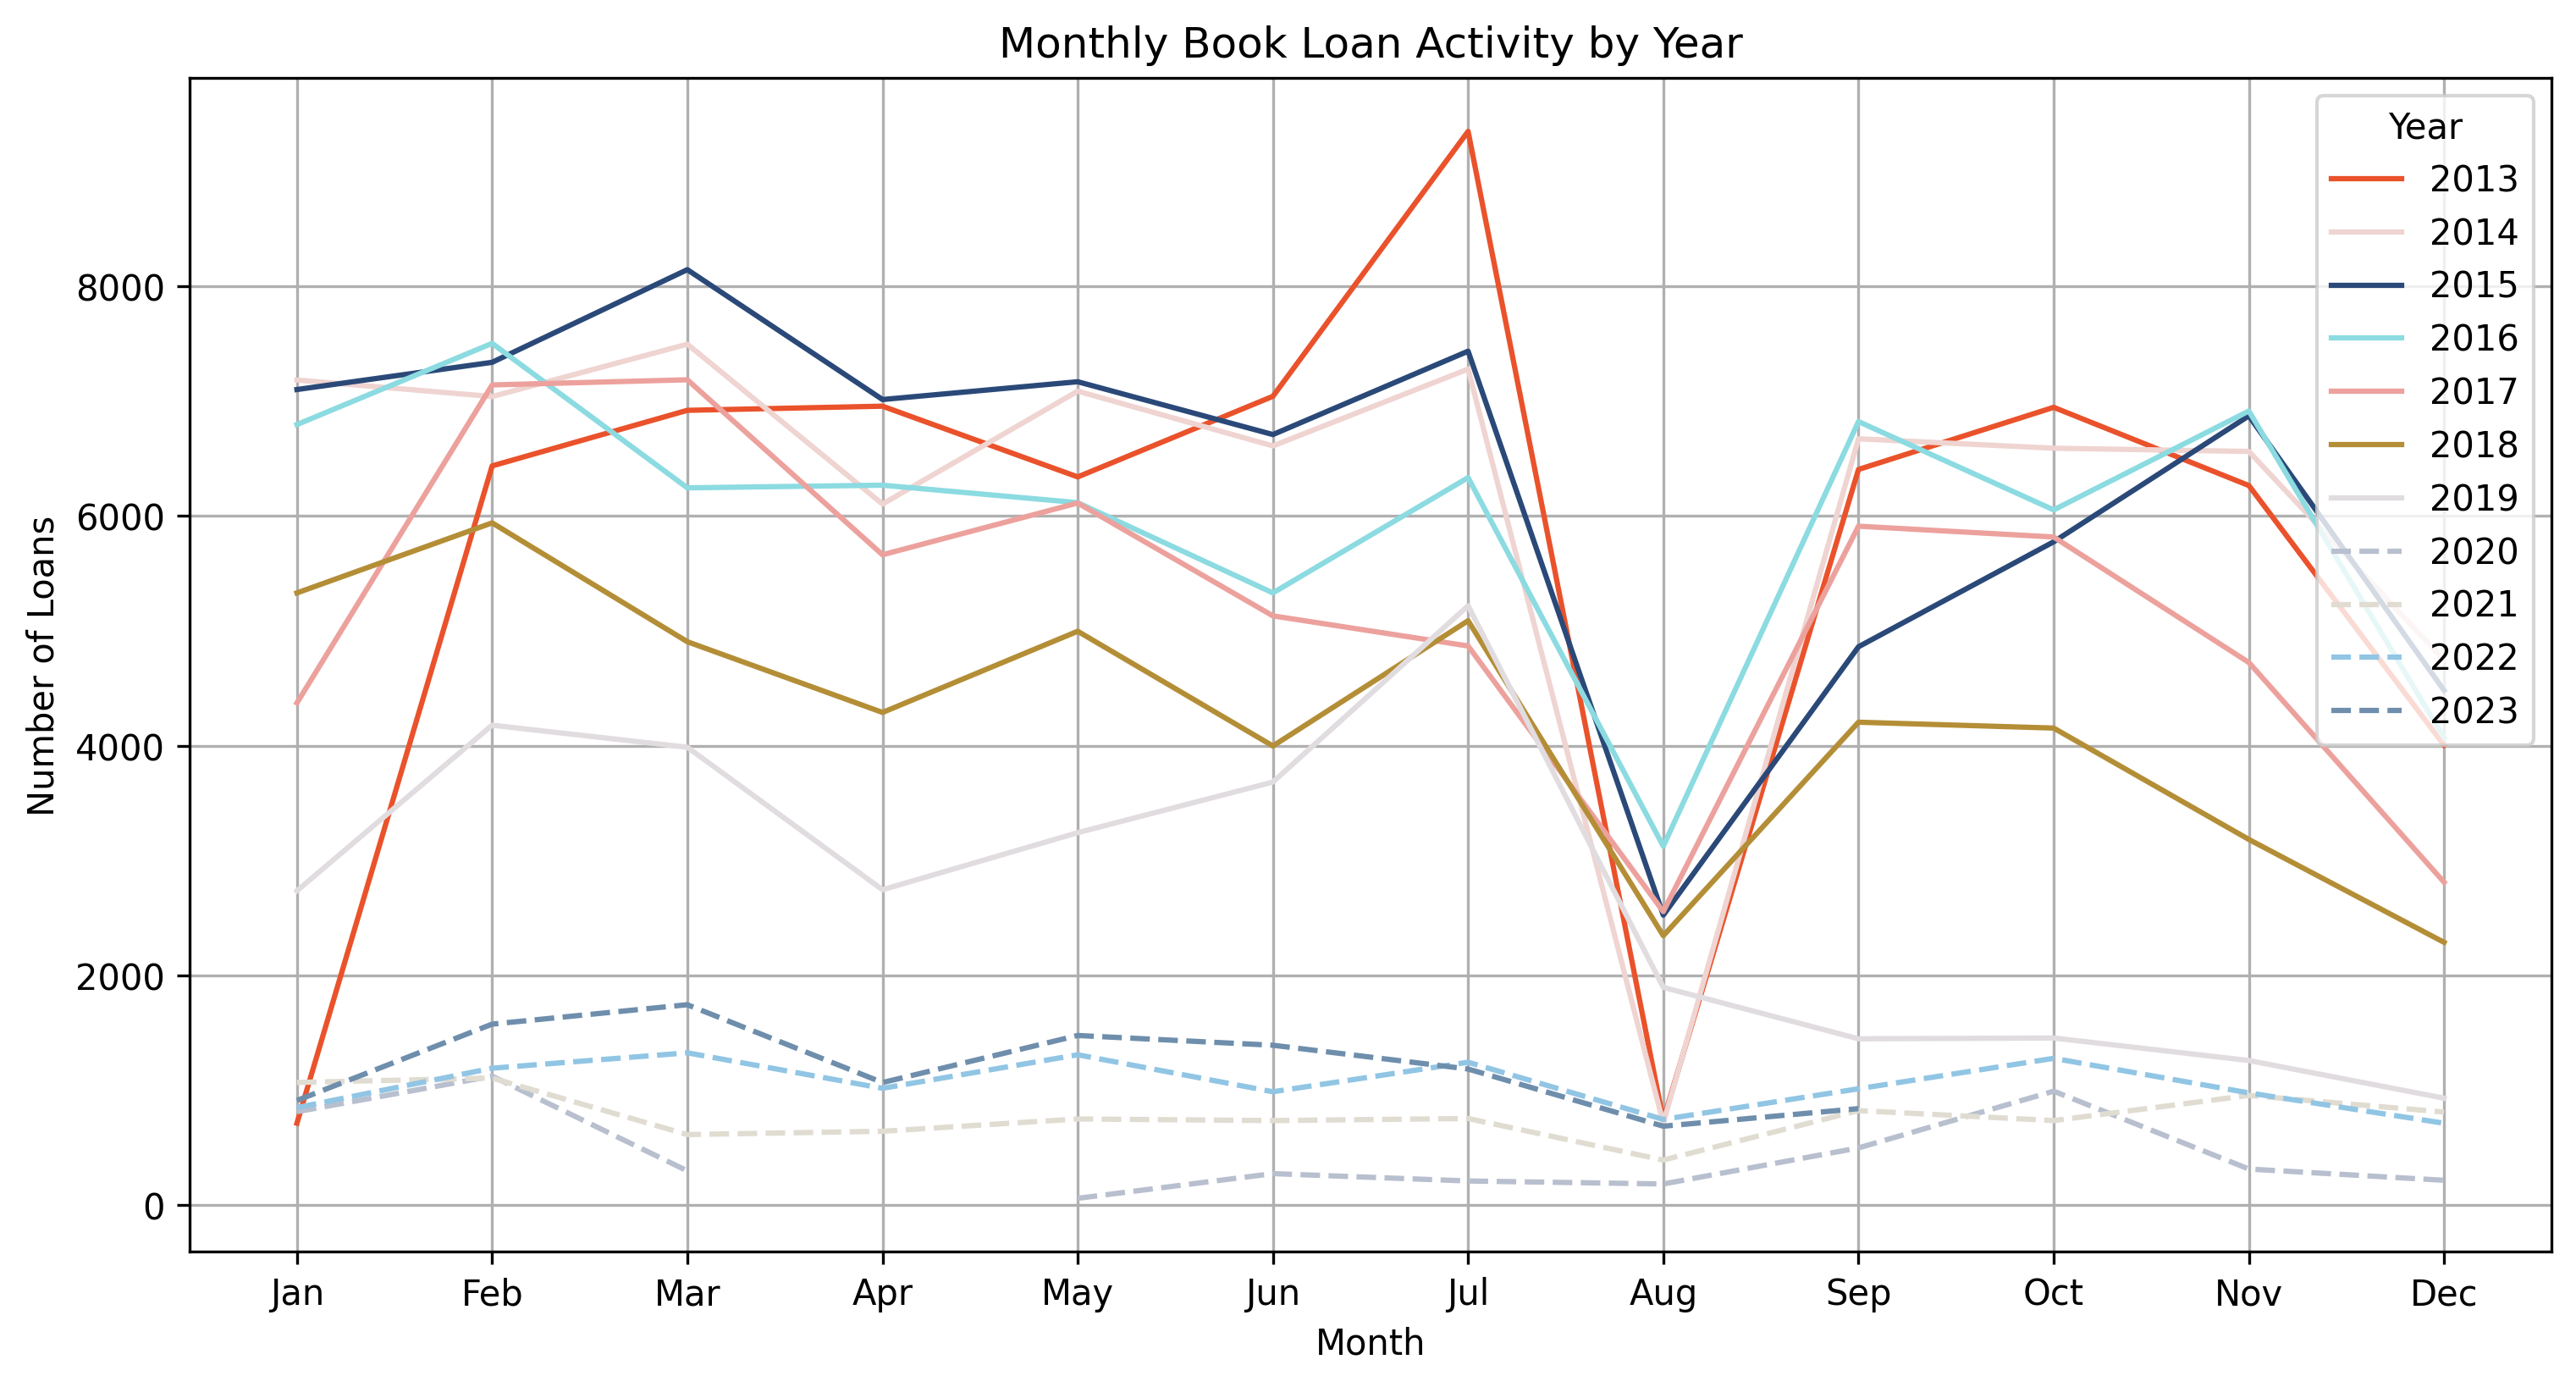

In [24]:

# Map books over time (e.g. a year, when is the library most active, when not so much)
loan_counts = user_df.groupby(['Year', user_df['Z36H_LOAN_DATE'].dt.month])['Z30_CALL_NO'].count().unstack()

# Create a line plot for each year with conditional line styles
plt.figure(figsize=(12, 6), dpi=300)
sns.set_palette(custom_colours)
for year in loan_counts.index:
    linestyle = '-' if year <= 2019 else '--'  # Dotted line for years after 2019
    plt.plot(loan_counts.columns, loan_counts.loc[year], label=f'{year}', linestyle=linestyle)

plt.title('Monthly Book Loan Activity by Year')
plt.xlabel('Month')
plt.ylabel('Number of Loans')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)
plt.legend(title='Year', loc='upper right')
plt.show()

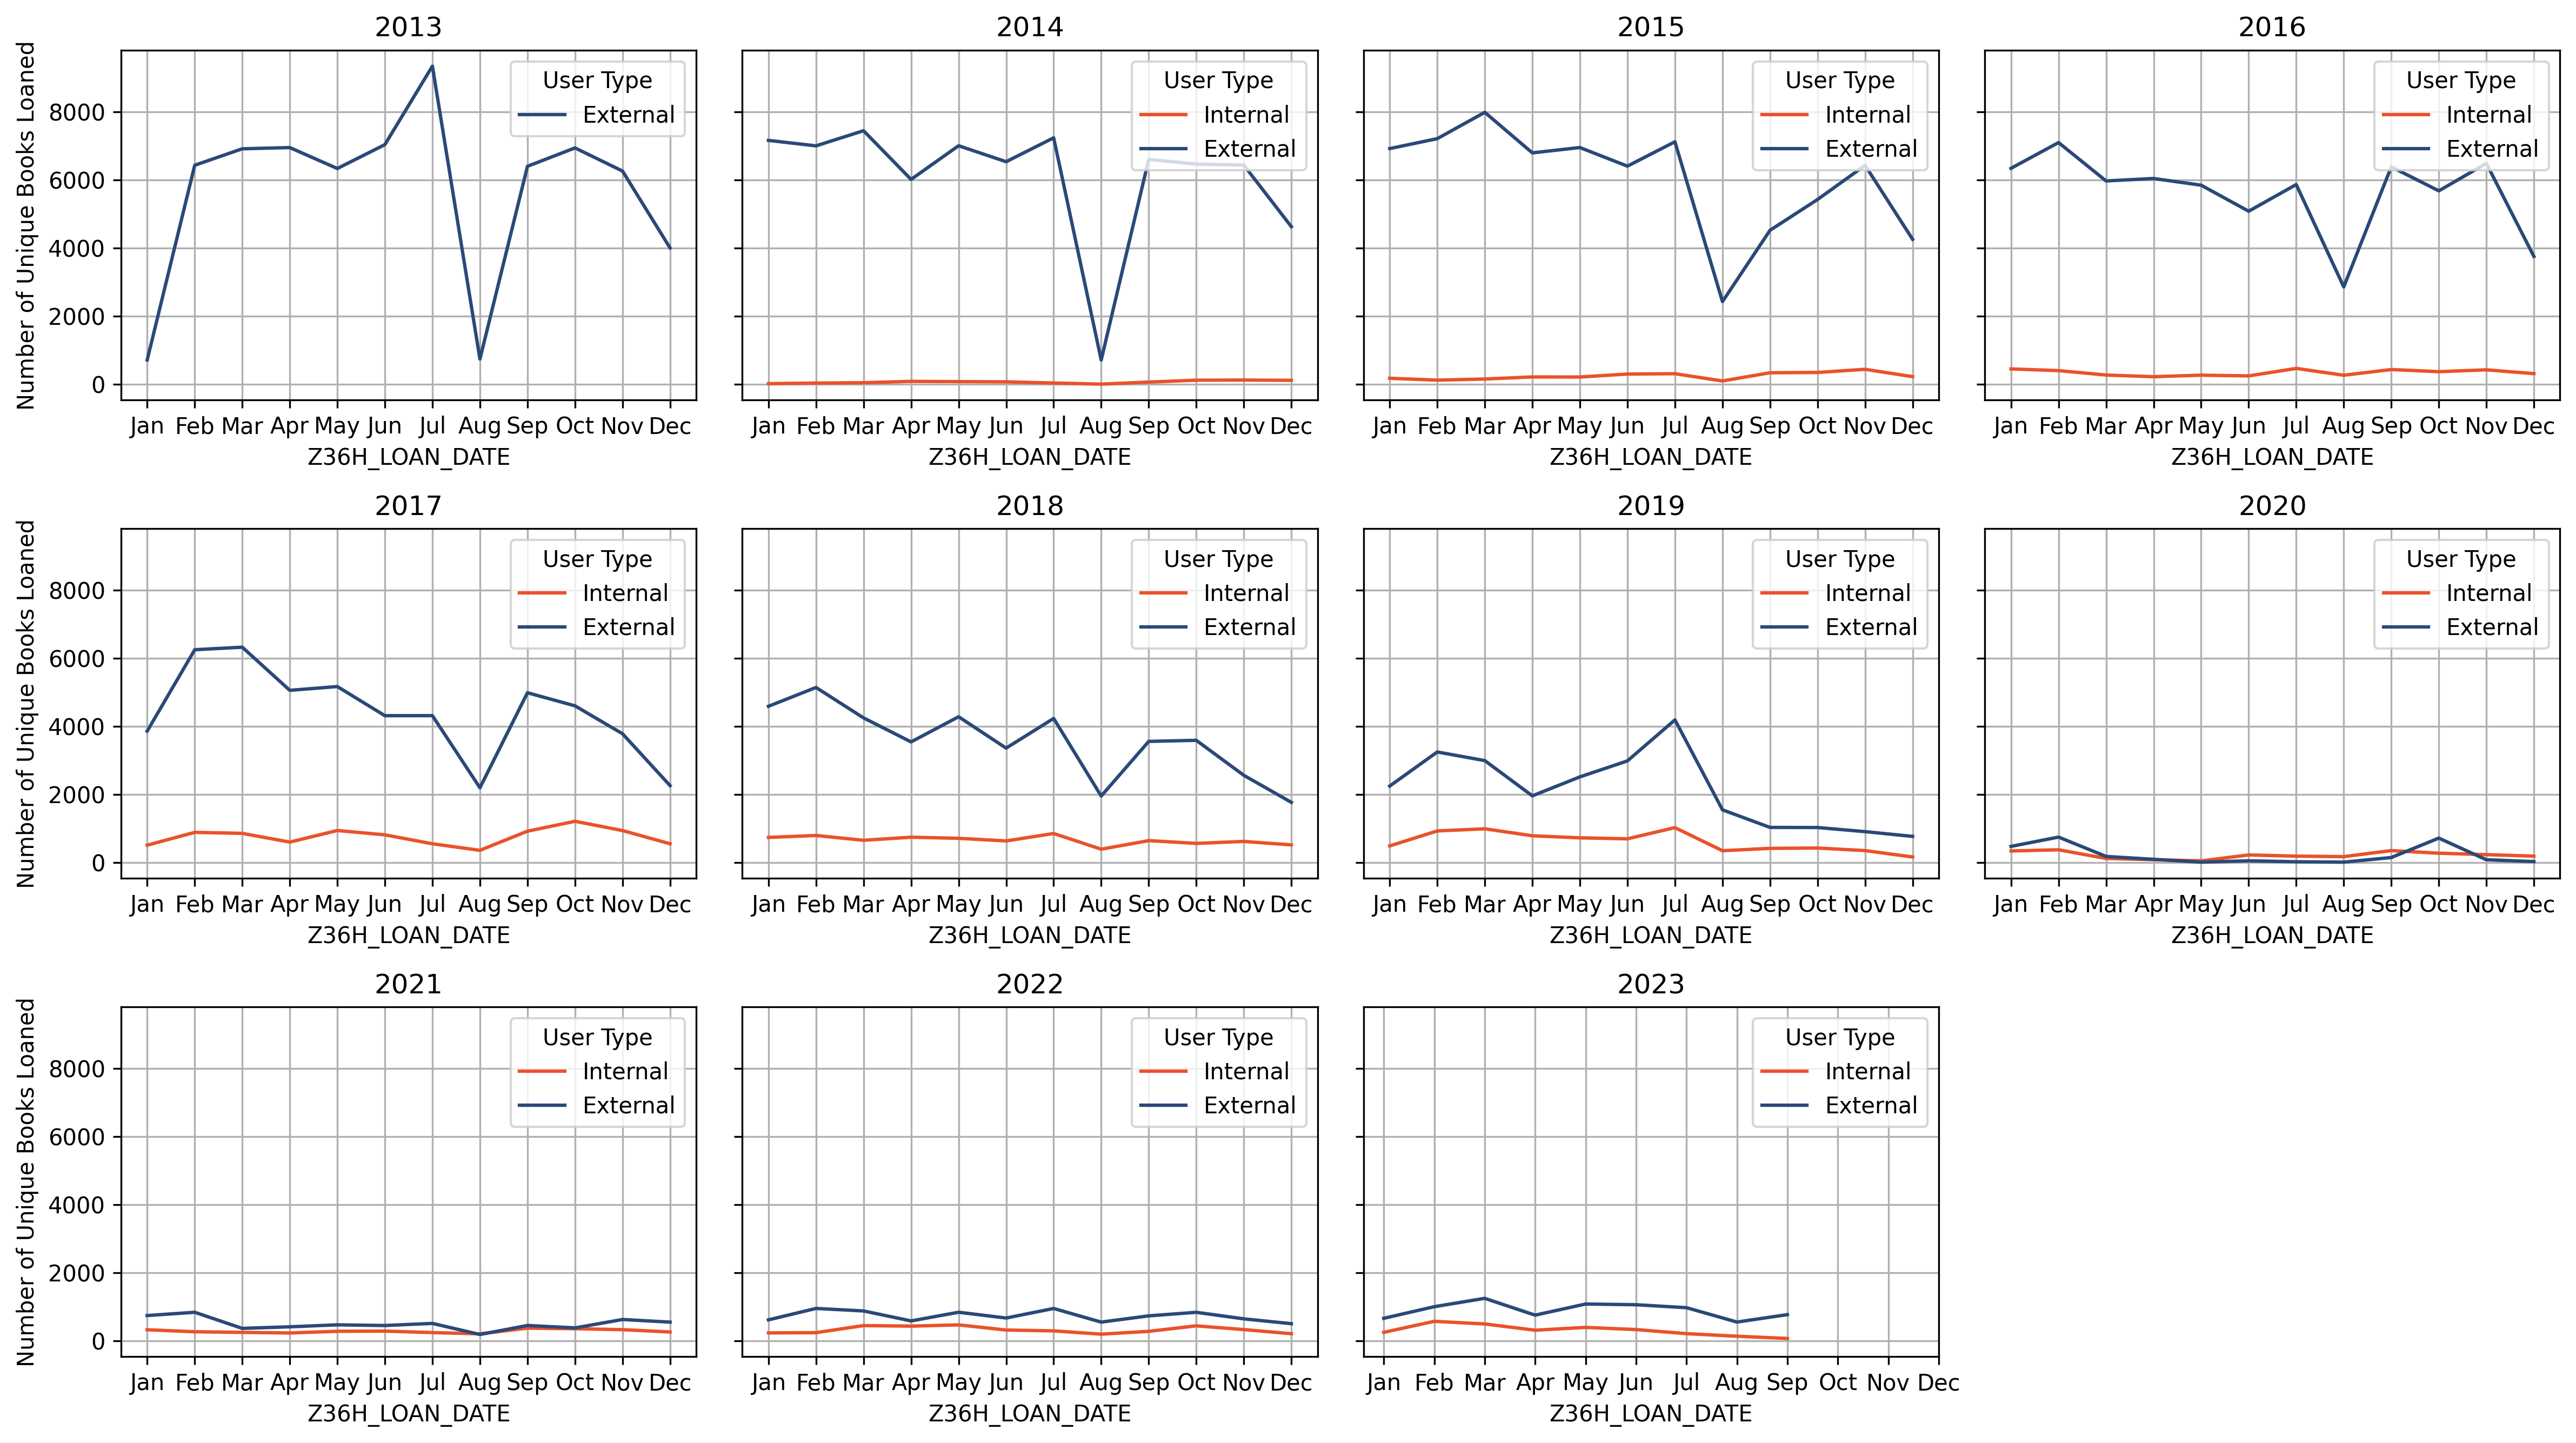

In [11]:

user_df['UserType'] = user_df['Z36H_ID'].apply(lambda x: 'Internal' if x.startswith('BHR') else 'External')

loan_counts = user_df.groupby(['Year', user_df['Z36H_LOAN_DATE'].dt.month, 'UserType'])['Z30_CALL_NO'].count()

unique_years = loan_counts.index.get_level_values('Year').unique()
num_rows = (len(unique_years) - 1) // 4 + 1 # subplots
fig, axes = plt.subplots(num_rows, 4, figsize=(16, 3 * num_rows), sharey=True, dpi= 300)  # Share the y-axis limit

for i, year in enumerate(unique_years):
    row, col = i // 4, i % 4
    ax = axes[row, col]

    data_year = loan_counts.loc[year].reset_index()

    # Filter data for internal and external users separately
    internal_data = data_year[data_year['UserType'] == 'Internal']
    external_data = data_year[data_year['UserType'] == 'External']

    # Set the palette for consistent colors
    sns.set_palette([user_type_colors['Internal'], user_type_colors['External']])

    # Create line plots for internal and external users
    sns.lineplot(data=internal_data, x='Z36H_LOAN_DATE', y='Z30_CALL_NO', label='Internal', ax=ax, color=user_type_colors['Internal'])
    sns.lineplot(data=external_data, x='Z36H_LOAN_DATE', y='Z30_CALL_NO', label='External', ax=ax, color=user_type_colors['External'])

    ax.set_title(f'{year}')
    ax.set_ylabel('Number of Unique Books Loaned')
    ax.set_xticks(range(1, 13))
    ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    ax.grid(True)
    ax.legend(title='User Type', loc='upper right')

# Hide empty subplots
for i in range(len(unique_years), num_rows * 4):
    row, col = i // 4, i % 4
    fig.delaxes(axes[row, col])

# To ensure proper spacing
plt.tight_layout()
plt.show()

# TODO: split years into pre and post covid



In [18]:
# Merge data with book metadata
freihand_path = 'data/hertziana_exp/freihand_signatures.csv'
freihand = pd.read_csv(freihand_path)

#Join with Freihand dataset to get more info 
merged_df = user_df.merge(freihand, left_on='Z30_CALL_NO', right_on='signature', how='inner')
print(merged_df.groupby('lang')['bvb'].count().sort_values(ascending=False))

#merged_df.to_csv('user_data/merged.csv', index=False)

#dataframes for top 4 langs
eng = merged_df[merged_df.lang == 'eng']
ita = merged_df[merged_df.lang == 'ita']
ger = merged_df[merged_df.lang == 'ger']
fre = merged_df[merged_df.lang == 'fre']

lang
ita    163160
eng     41288
ger     21801
fre     10269
und      1439
lat      1394
spa      1293
dut       249
gre       118
cat        96
por        92
rum        88
pol        78
rus        60
hrv        46
mul        38
cze        32
srp        30
swe        29
dan        29
lit        27
hun        22
jpn        18
grc        16
gmh        13
fin         9
slv         8
bul         6
arm         5
slo         5
nor         4
nep         3
scr         2
geo         2
tur         1
baq         1
heb         1
mac         1
ara         1
Name: bvb, dtype: int64


In [14]:
# How many different books

# map languages of books

# Do users get books only in one language or multiple? 

# How long are users there, do they come back etc.?

In [16]:
eng.columns

Index(['Z30_CALL_NO', 'Z30_COLLECTION', 'Z30_BARCODE', 'Z30_INVENTORY_NUMBER',
       'Z30_DESCRIPTION', 'Z30_NO_LOANS', 'Z36H_LOAN_DATE',
       'Z36H_RETURNED_DATE', 'Z36H_ID', 'Z36H_LOAN_CATALOGER_NAME',
       'Z13_TITLE', 'Year', 'UserType', 'bvb', 'title', 'signature',
       'inventory_nr', 'inventory_date', 'inventory_year', 'lang', 'year',
       'sys', 'text', 'text_1', 'text_2', 'text_3', 'sig_lev_1', 'sig_lev_2'],
      dtype='object')

In [17]:
eng

,Z30_CALL_NO,Z30_COLLECTION,Z30_BARCODE,Z30_INVENTORY_NUMBER,Z30_DESCRIPTION,Z30_NO_LOANS,Z36H_LOAN_DATE,Z36H_RETURNED_DATE,Z36H_ID,Z36H_LOAN_CATALOGER_NAME,...,inventory_year,lang,year,sys,text,text_1,text_2,text_3,sig_lev_1,sig_lev_2
20,Cm-PON 7500-6112/1,BIB,E004010042EB5DA0,2012.645,NaN,1.0,2020-06-09,2022-02-28,BHR-980,SELFCHECK,...,2012.0,eng,2011.0,Cm-PON 7500,"Ponti,_Gio",Italienische_Künstler,Moderne_Künstler_(geboren_nach_1870),NaN,C,Cm
142,Mb 705-6113,BIB,E0040100441E533C,2014.4647,NaN,17.0,2020-01-22,2022-12-19,MPG000012293,WWW-OPAC,...,2014.0,eng,2011.0,Mb 705,Kunst_und_Religion,Kunst_allgemein_(ohne_Italien_speziell),Theoretische_Grundlagen_und_Randgebiete_der_Ku...,Motivgeschichtliche_Monographien,M,Mb
143,Mb 705-6113,BIB,E0040100441E533C,2014.4647,NaN,17.0,2019-07-17,2019-07-18,MPG000012840,SELFCHECK,...,2014.0,eng,2011.0,Mb 705,Kunst_und_Religion,Kunst_allgemein_(ohne_Italien_speziell),Theoretische_Grundlagen_und_Randgebiete_der_Ku...,Motivgeschichtliche_Monographien,M,Mb
144,Mb 705-6113,BIB,E0040100441E533C,2014.4647,NaN,17.0,2019-07-18,2019-07-19,MPG000012848,SELFCHECK,...,2014.0,eng,2011.0,Mb 705,Kunst_und_Religion,Kunst_allgemein_(ohne_Italien_speziell),Theoretische_Grundlagen_und_Randgebiete_der_Ku...,Motivgeschichtliche_Monographien,M,Mb
145,Mb 705-6113,BIB,E0040100441E533C,2014.4647,NaN,17.0,2019-07-15,NaT,MPG000012826,SELFCHECK,...,2014.0,eng,2011.0,Mb 705,Kunst_und_Religion,Kunst_allgemein_(ohne_Italien_speziell),Theoretische_Grundlagen_und_Randgebiete_der_Ku...,Motivgeschichtliche_Monographien,M,Mb
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
402019,Br 425-5380/4,BIB,E0040100413A66C2,NaN,NaN,1.0,2012-09-08,2014-03-28,MPG000012303,SELFCHECK,...,NaN,eng,1938.0,Br 425,Anfänge_des_Holz-_und_Metallschnitts_(15._Jh.)...,Italienische_Kunst,Graphik,Geschichte_der_Graphik_nach_Gattungen,B,Br
402021,Br 255-5030/2 gr,BIB,E00401080E88A790,NaN,NaN,1.0,2012-10-22,2013-02-27,MPG000012474,WWW-OPAC,...,NaN,eng,1903.0,Br 255,"Geschichte_der_Handzeichnung_in_der_Neuzeit,_M...",Italienische_Kunst,Graphik,Geschichte_der_Graphik_nach_Gattungen,B,Br
402160,E-TIV 12-5080,BIB,E004010042EDC0CB,NaN,NaN,1.0,2012-10-21,2016-01-25,MPG000012265,WWW-OPAC,...,NaN,eng,1908.0,E-TIV 12,kunstgeschichtliche_Literatur,Topographie_Italien_(ohne_Rom),Tivoli,NaN,E,E-
402183,Xr-SAN 3982-6020 gr,BIB,E0040100438583C0,2012.229,NaN,2.0,2012-07-19,2012-07-19,MPG000012251,SELFCHECK,...,2012.0,eng,2002.0,Xr-SAN 3982,kunstgeschichtliche_Literatur,Topographie_Europa_(ohne_Italien),Europäische_Sowjetunion_(einschließlich_baltis...,Sankt_Petersburg,X,Xr


### Topic extraction from titles using LDA (try out with english)

In [33]:
df = eng

# #spacy model eng
# nlp = spacy.load('en_core_web_sm')

# # Tokenize and unstopword titles (is_alpha = alphabetic)
# def preprocess(title):
#     doc = nlp(title)
#     tokens = [token.lemma_ for token in doc if not token.is_stop and token.is_alpha]
#     return " ".join(tokens)

# titles = [preprocess(title) for title in df.Z13_TITLE]

#tf-idf the titles 
tfidf_vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1,1), stop_words= 'english')
tfidf_matrix = tfidf_vectorizer.fit_transform(df.Z13_TITLE)

In [36]:
# Latent Dirichlet Allocation for topic extraction

num_topics = 20 
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda.fit(tfidf_matrix)

topic_assignments = lda.transform(tfidf_matrix).argmax(axis=1)

for topic_idx, topic in enumerate(lda.components_):
    print(f"Topic {topic_idx + 1}:")
    top_words = [tfidf_vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-10 - 1:-1]]
    print(", ".join(top_words))

Topic 1:
antiquity, ravenna, late, tomb, renaissance, german, art, raphael, mannerism, 1400
Topic 2:
power, painters, book, drawing, memory, renaissance, art, vatican, science, bartolomeo
Topic 3:
sculpture, renaissance, pictures, sacchi, artists, maria, andrea, pirro, ligorio, antique
Topic 4:
andrea, del, sarto, self, portraiture, renaissance, art, interior, perino, vaga
Topic 5:
early, modern, rome, sculpture, art, medieval, painting, century, identity, parmigianino
Topic 6:
art, renaissance, patronage, sixteenth, court, reformation, italy, century, medici, italian
Topic 7:
private, bibliographical, repertory, collections, italian, seventeenth, roman, time, palaces, rome
Topic 8:
genoa, sea, history, art, neapolitan, rosa, salvator, english, dictionary, collectors
Topic 9:
saint, zuccaro, taddeo, federico, monastery, christian, culture, catherine, sinai, mount
Topic 10:
rome, carracci, annibale, antonio, architectural, drawings, giovanni, da, circle, sangallo
Topic 11:
dutch, 1700, 